# 0X_tree_models



In [228]:
import os
import math
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.metrics import accuracy_score

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

import statsmodels.formula.api as sm

# Avoid scientific notation output in Pandas
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.float_format = '{:,.2f}'.format
import logging

# Improve resolution of output graphcis
%matplotlib inline
%config InlineBackend.figure_format ='retina'

from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important;}</style>"))

import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.append('..')

In [3]:
# !pip install graphviz
# !brew install graphviz
from sklearn import tree
import graphviz

In [4]:
from src.scale import *
from src.model import *
from src.visualize import *
from src.datagen import generate_interval_data

## Get Project Data Based on Interval

In [5]:
file_path_train = '../data/processed/NYC_capital_projects_3yr_final_train.csv'
file_path_test = '../data/processed/NYC_capital_projects_3yr_final_test.csv'
    
if os.path.isfile(file_path_train) and os.path.isfile(file_path_test):
    print("OK - path points to file.")
else:
    print("ERROR - check the 'file_path' and ensure it points to the source file.")

OK - path points to file.


In [8]:
data_train = pd.read_csv(file_path_train)
data_test = pd.read_csv(file_path_test)

## Manually Collapse Categories

## Select Attributes (X) and Target Values (Y)

In [76]:
# All possible (reasonable) Attributes
X_cols_all = [
    'Category',
    'Borough',
    'Managing_Agency',
    'Client_Agency',
    'Budget_Start',
    'Duration_Start'
]

# includes +/- values of total change
y_cols_change = [
    'Budget_Change',
    'Schedule_Change'
]

# final budget amount and duration
y_cols_end_value = [
    'Budget_End',
    'Duration_End'
]

# includes +/- values of relative change
y_cols_ratio = [
    'Budget_Change_Ratio',
    'Schedule_Change_Ratio'
]

categories = ['Bridges', 'Ferries', 'Industrial_Development', 'Parks', 'Sanitation', 'Schools', 'Sewers', 'Streets_and_Roadways', 'Wastewater_Treatment', 'Water_Supply']


## Define functions for fitting and evaluating models

In [23]:
# Decision Tree 

depths = list(range(1, 21))
cv = 5

def calc_meanstd(X_tr, y_tr, X_te, y_te, depths:list=depths, cv:int=cv, logistic=True):
    # your code here
    cvmeans = []
    cvstds = []
    train_scores = []
    test_scores = []
    models = []
    
    for d in depths:
        # make a pipeline object with model
        if logistic:
            model = DecisionTreeClassifier(max_depth=d, random_state=0)
        else:
            model = DecisionTreeRegressor(max_depth=d, random_state=0)
           
        model.fit(X_tr, y_tr) # train model
        
        # cross validation
        cvmeans.append(np.mean(cross_val_score(model, X_tr, y_tr, cv=cv, scoring='accuracy' if logistic else 'r2')))
        cvstds.append( np.std (cross_val_score(model, X_te, y_te, cv=cv, scoring='accuracy' if logistic else 'r2')))

        train_scores.append( model.score(X_tr, y_tr) )  # append train score - picks accuracy or r2 automatically
        test_scores.append(  model.score(X_te, y_te) ) # append cv test score - picks accuracy or r2 automatically
        models.append(model)

    # make the lists np.arrays
    cvmeans = np.array(cvmeans)
    cvstds = np.array(cvstds)
    train_scores = np.array(train_scores)
    test_scores = np.array(test_scores)
   
    # end of your code here
    return cvmeans, cvstds, train_scores, test_scores, models

In [109]:
# get the x and y 
def define_train_and_test(data_train, data_test, attributes, response, logistic) -> (pd.DataFrame, pd.DataFrame):
    X_tr = data_train[attributes]
    y_tr = data_train[response]

    X_te = data_test[attributes]
    y_te = data_test[response]
    
    if logistic:
        y_tr = (y_tr>0)*1
        y_te = (y_te>0)*1
    
    return X_tr, X_te, y_tr, y_te

In [334]:
# Plot tree
def plot_tree(data_train, data_test, attributes:list, responses_list:list, logistic=True, plot=True):
    
    if logistic:
#         print("Using Logistic Model")
        model_type = 'Logistic'
        score_type = 'accuracy'
    else:
#         print("Using Regression Model")
        model_type = 'Regression'
        score_type = 'r2'
        
    results = []
    
    # remove multi-output responses, if not using logistic regression
    responses = [] 
    for r in responses_list:
        if type(r) == str:
            r = [r]
        if len(r) > 1 and not logistic:
            continue
        responses.append(r)
        
    # update the attributes to use dummies if 'category' is included
    attrs = attributes.copy()
    if 'Category' in attrs:
        attrs.remove('Category')
        attrs += categories
       
    if 'umap_attributes_2D_embed' in attrs:
        attrs.remove('umap_attributes_2D_embed')
        attrs += ['umap_attributes_2D_embed_1', 'umap_attributes_2D_embed_2']
        
    # ensure that only 1 embedding is selected
    count = 0
    embedding = None
    for i in ['umap_descr_2D_embed', 'ae_descr_embed', 'pca_descr_embed']:
        if i in attrs:
            count += 1
            embedding = i
    if count > 1:
        print("ERROR")
        print("Only one of the three embeddings is allowed.")
        return
    
    if embedding in attrs:
        attrs.remove(embedding)
        attrs += [f'{embedding}_1', f'{embedding}_2']
    
    if plot:
        fig, ax = plt.subplots(ncols = len(responses), figsize=(15,6))
    
    for i, response in enumerate(responses):

        X_tr, X_te, y_tr, y_te = define_train_and_test(data_train, data_test, attrs, response, logistic)
        cvmeans, cvstds, train_scores, test_scores, models = calc_meanstd(X_tr, 
                                                                          y_tr[response], 
                                                                          X_te, 
                                                                          y_te[response],
                                                                          logistic=logistic)
        
        if logistic:
            best_model = models[cvmeans.argmax()]
            best_cv_score = np.round(cvmeans.max(),2)
            best_depth = cvmeans.argmax()+1
        else:
            best_model = models[test_scores.argmax()]
            best_cv_score = np.round(test_scores.max(),2)
            best_depth = test_scores.argmax()+1

        x = np.array(depths)
        y = cvmeans

        #Plot
        if plot:
            if logistic:
                ax[i].fill_between(x, y + 2*cvstds, y - 2*cvstds, alpha=0.2, color='g')


            ax[i].set_xlabel("Maximum Tree Depth")

            attrs_title = '\n'.join(attributes)
            title = f"Model: {model_type}\nResp: {response}\nAttrs: {attrs_title}"

            ax[i].set_title(f"{title}\nBest cv-test {score_type.capitalize()} score: {best_cv_score} at depth {best_depth}", fontsize=10)
            ax[i].set_ylabel(f"{score_type.capitalize()} Score")
            ax[i].set_xticks(depths)

            # Plot Cross-Validation Scores
            if logistic:
                ax[i].plot(x, y, 'g-', marker='x', label=f"Mean CV {score_type.capitalize()} Score")

            # Plot model train scores
            ax[i].plot(x, train_scores, 'b-', marker='o', label=f"Model Train {score_type.capitalize()} Score")

            # Plot model test scores
            ax[i].plot(x, test_scores, 'o-', marker='.', label=f"Model Test {score_type.capitalize()} Score")

            if i == len(responses)-1:
                ax[i].legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
        
        results.append({'attributes':attributes,
                        'full_attributes':attrs,
                        'responses':response,
                        'Budget_Change': 1 if 'Budget_Change' in response and len(response) == 1 else 0,
                        'Schedule_Change': 1 if 'Schedule_Change' in response and len(response) == 1 else 0,
                        'Budget_and_Schedule_Change': 1 if len(response) == 2 else 0,
                        'best_cv_score':best_cv_score,
                        'best_depth':best_depth,
                        'train_score':train_scores[best_depth-1],
                        'test_score':test_scores[best_depth-1],
                        'best_model':best_model
                       })
        
    desc = f"{'Logistic' if logistic else 'Regression'} Tree. Depth: {best_depth}"
    X_tr, X_te, y_tr, y_te = define_train_and_test(data_train, data_test, attrs, ['Budget_Change', 'Schedule_Change'], logistic=logistic)

    model_dict = generate_model_dict(model=DecisionTreeClassifier if logistic else DecisionTreeRegressor, 
                                             model_descr=desc, 
                                             X_train=X_tr, 
                                             X_test=X_te, 
                                             y_train=y_tr, 
                                             y_test=y_te, 
                                             multioutput=logistic,
                                             verbose=False,
                                             predictions=True,
                                             scores=True,
                                             model_api='sklearn',
                                             sm_formulas=None,
                                             y_stored=True,
                                             max_depth=best_depth, 
                                             random_state=109)
    
#     if not logistic and plot:
#         print_model_results(model_dict)
#         plot_true_pred(model_dict)
    
    return results, model_dict


## Fit and evaluate Decision Tree Models based on various attribute and response variable combinations

## Using Logistic Models
Here, we only predict whether the final values are higher or lower than the original start.

In [349]:
# calculate all combinations of modeling options of attribute and responses
results_all = []
model_dicts = []

nondescr_attrbutes = ['Category', 'Budget_Start', 'Duration_Start', 'umap_attributes_2D_embed']
descr_attributes = ['umap_descr_2D_embed', 'ae_descr_embed', 'pca_descr_embed']
logistic = True
print("Using LOGISTIC models")
for i in tqdm(range(1, len(nondescr_attrbutes))):
    alist = list(itertools.combinations(nondescr_attrbutes, i))
    for a in tqdm(alist, leave=False):
        a = list(a)
        results, model_dict = plot_tree(data_train, data_test, attributes=a, responses_list=responses_list, logistic=logistic, plot=False)
        results_all += results
        model_dicts.append(model_dict)
        for d_emb in tqdm(descr_attributes, leave=False):
            results, model_dict = plot_tree(data_train, data_test, attributes=a + [d_emb], responses_list=responses_list, logistic=logistic, plot=False)
            results_all += results
            model_dicts.append(model_dict)
    

Using LOGISTIC models


In [350]:
results_df = pd.DataFrame(results_all)
results_df.sort_values(by='test_score', ascending=False)

,attributes,full_attributes,responses,Budget_Change,Schedule_Change,Budget_and_Schedule_Change,best_cv_score,best_depth,train_score,test_score,best_model
74,"[Category, umap_attributes_2D_embed]","[Bridges, Ferries, Industrial_Development, Par...",[Schedule_Change],0,1,0,0.78,10,0.93,0.87,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
44,"[umap_attributes_2D_embed, ae_descr_embed]","[umap_attributes_2D_embed_1, umap_attributes_2...",[Schedule_Change],0,1,0,0.75,6,0.86,0.87,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
38,[umap_attributes_2D_embed],"[umap_attributes_2D_embed_1, umap_attributes_2...",[Schedule_Change],0,1,0,0.76,1,0.76,0.80,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
137,"[Category, Budget_Start, umap_attributes_2D_em...","[Budget_Start, Bridges, Ferries, Industrial_De...",[Schedule_Change],0,1,0,0.78,4,0.78,0.80,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
149,"[Category, Duration_Start, umap_attributes_2D_...","[Duration_Start, Bridges, Ferries, Industrial_...",[Schedule_Change],0,1,0,0.76,1,0.76,0.80,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
...,...,...,...,...,...,...,...,...,...,...,...
70,"[Category, Duration_Start, pca_descr_embed]","[Duration_Start, Bridges, Ferries, Industrial_...",[Budget_Change],1,0,0,0.69,5,0.89,0.40,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
91,"[Budget_Start, Duration_Start, ae_descr_embed]","[Budget_Start, Duration_Start, ae_descr_embed_...",[Budget_Change],1,0,0,0.65,6,0.94,0.33,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
84,"[Budget_Start, Duration_Start]","[Budget_Start, Duration_Start]","[Budget_Change, Schedule_Change]",0,0,1,0.39,7,0.84,0.27,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
61,"[Category, Duration_Start]","[Duration_Start, Bridges, Ferries, Industrial_...",[Budget_Change],1,0,0,0.64,7,0.91,0.20,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."


### Review Best Performing Model with 'Schedule Change' Response


Index Chosen: 44
Best Test Score of Model Chosen: 0.8667 // Depth: 6
Model Attributes: ['umap_attributes_2D_embed', 'ae_descr_embed']
Model Response: ['Schedule_Change']


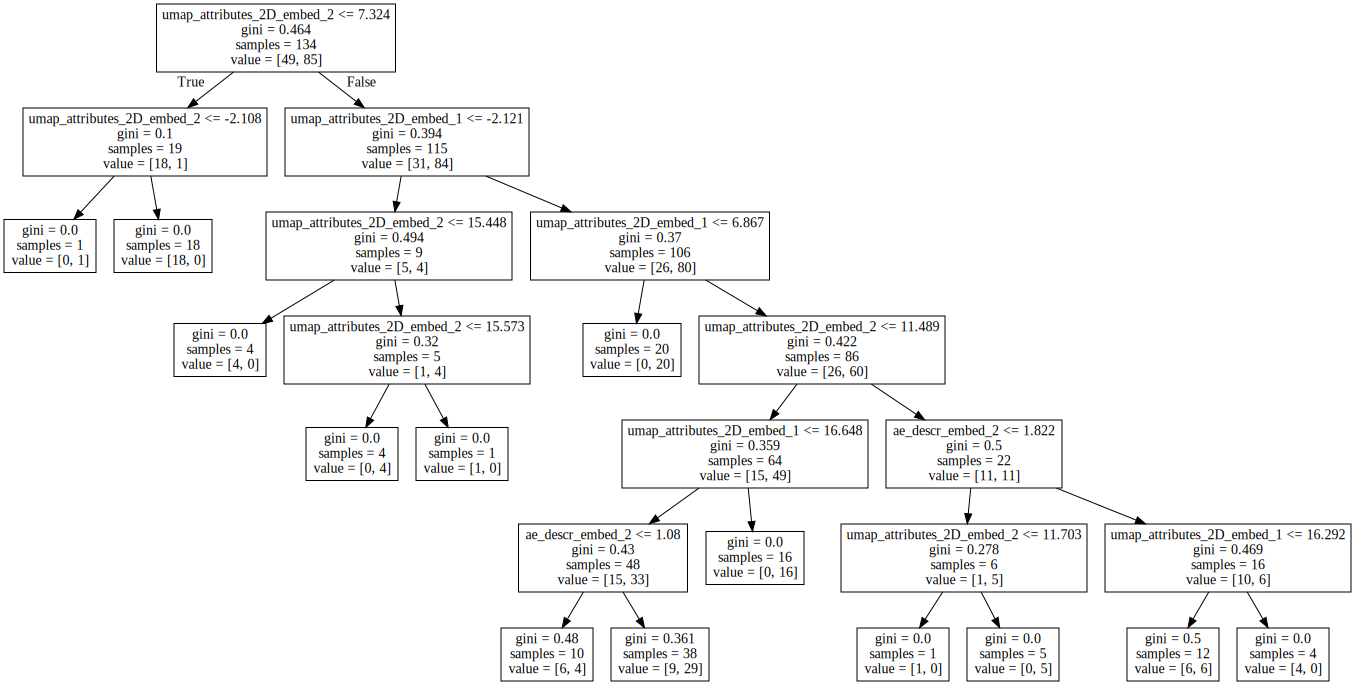

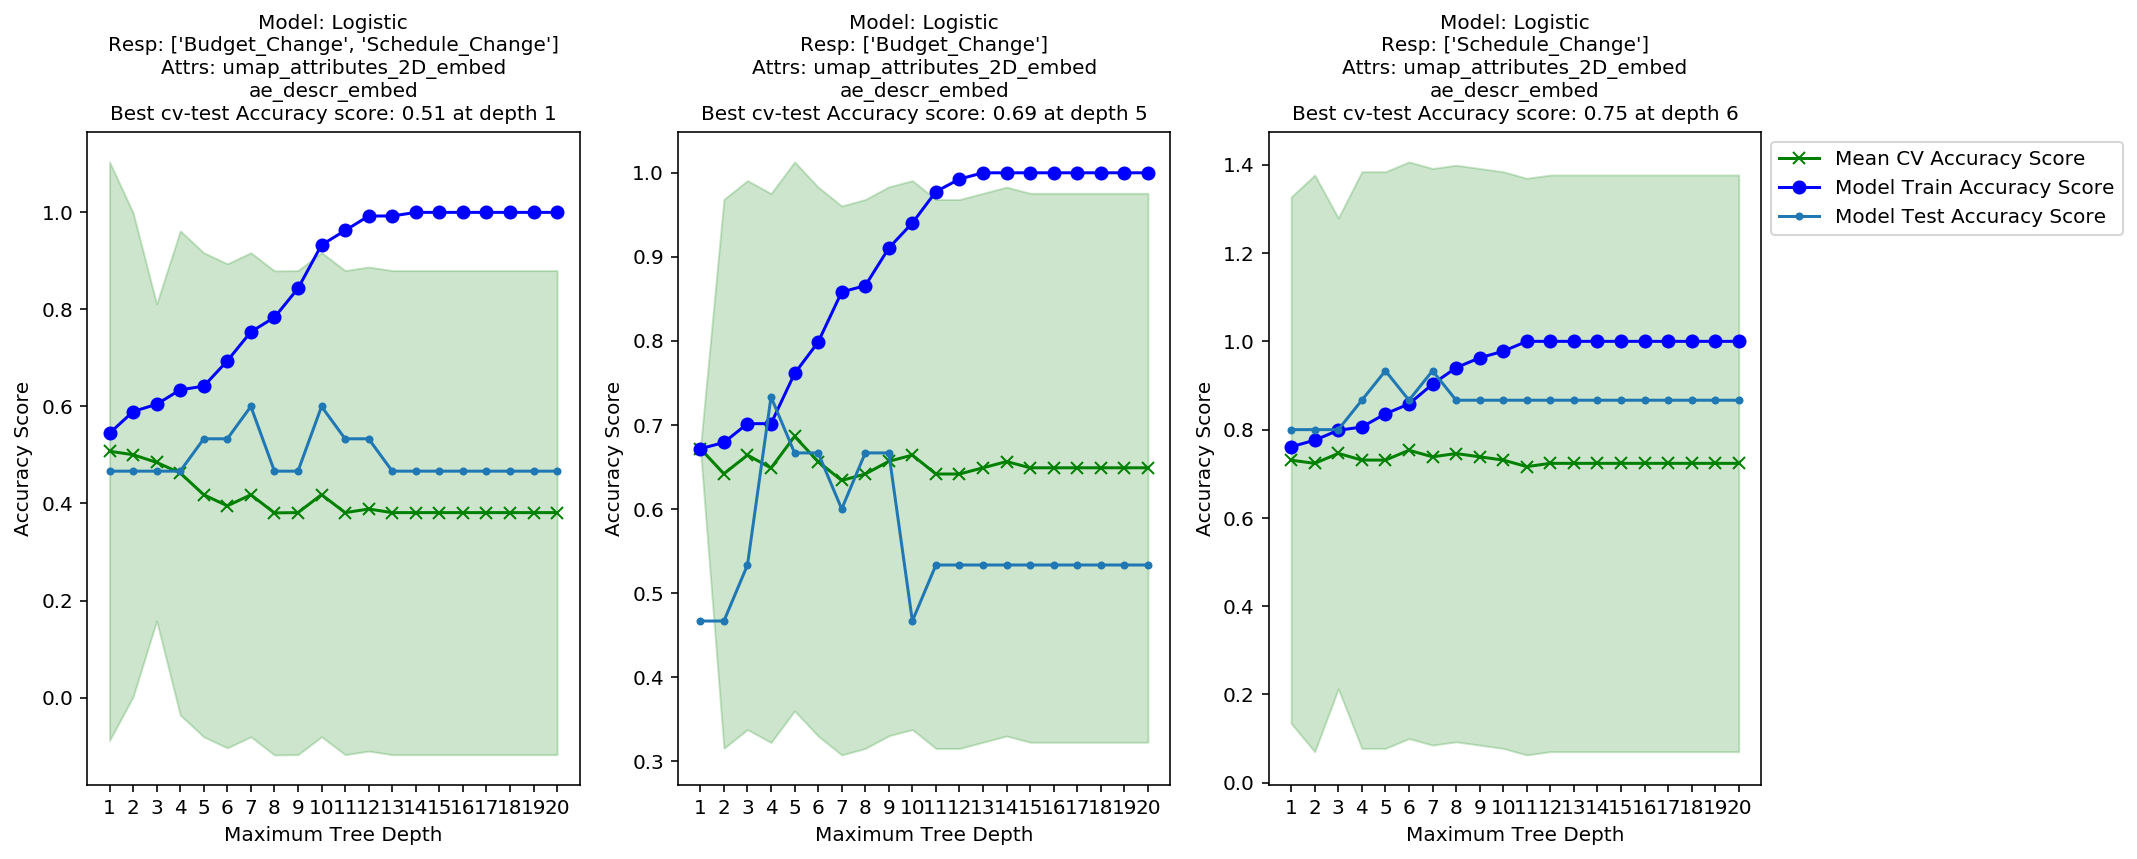

In [351]:
resp = 'Schedule_Change'
max_score = results_df[log_results_df[resp]==1].test_score.max()
idx = results_df[(results_df[resp]==1) & (results_df.test_score==max_score)].sort_values(by='best_cv_score').iloc[0].name
print(f"Index Chosen: {idx}")

m_dict = results_df.iloc[idx]
attributes = m_dict.attributes
responses_list = [['Budget_Change','Schedule_Change'], ['Budget_Change'], ['Schedule_Change']]
_, _ = plot_tree(data_train, data_test, attributes=attributes, responses_list=responses_list, logistic=logistic, plot=True)

print(f"Best Test Score of Model Chosen: {round(m_dict.get('test_score'),4)} // Depth: {m_dict.get('best_depth')}")
print(f"Model Attributes: {m_dict.get('attributes')}")
print(f"Model Response: {m_dict.get('responses')}")

tree_dot_data = tree.export_graphviz(m_dict.best_model, feature_names=m_dict.full_attributes)
gr = graphviz.Source(tree_dot_data)
display(gr)

### Review Best Performing Model with 'Budget Change' Response


Index Chosen: 43
Best Test Score of Model Chosen: 0.6667 // Depth: 5
Model Attributes: ['umap_attributes_2D_embed', 'ae_descr_embed']
Model Response: ['Budget_Change']


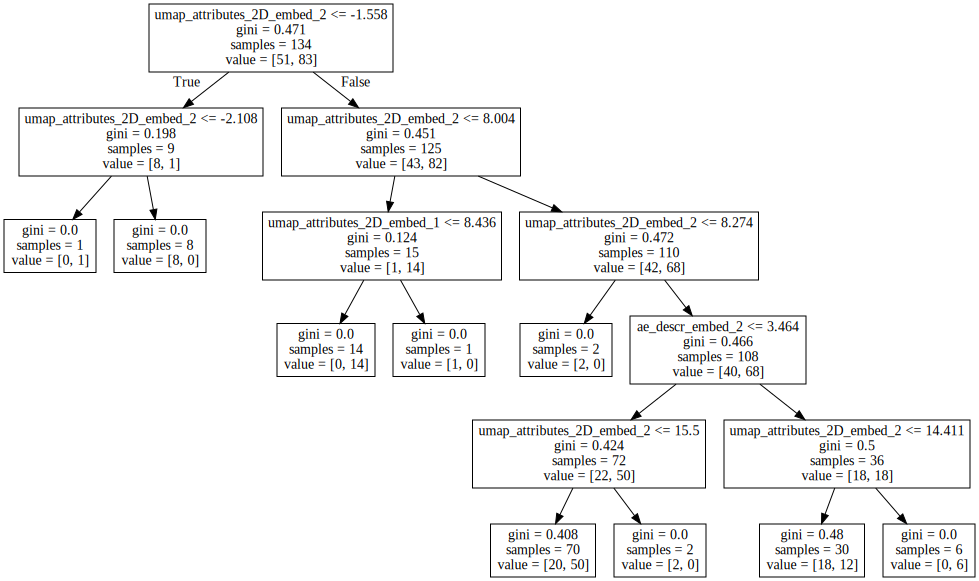

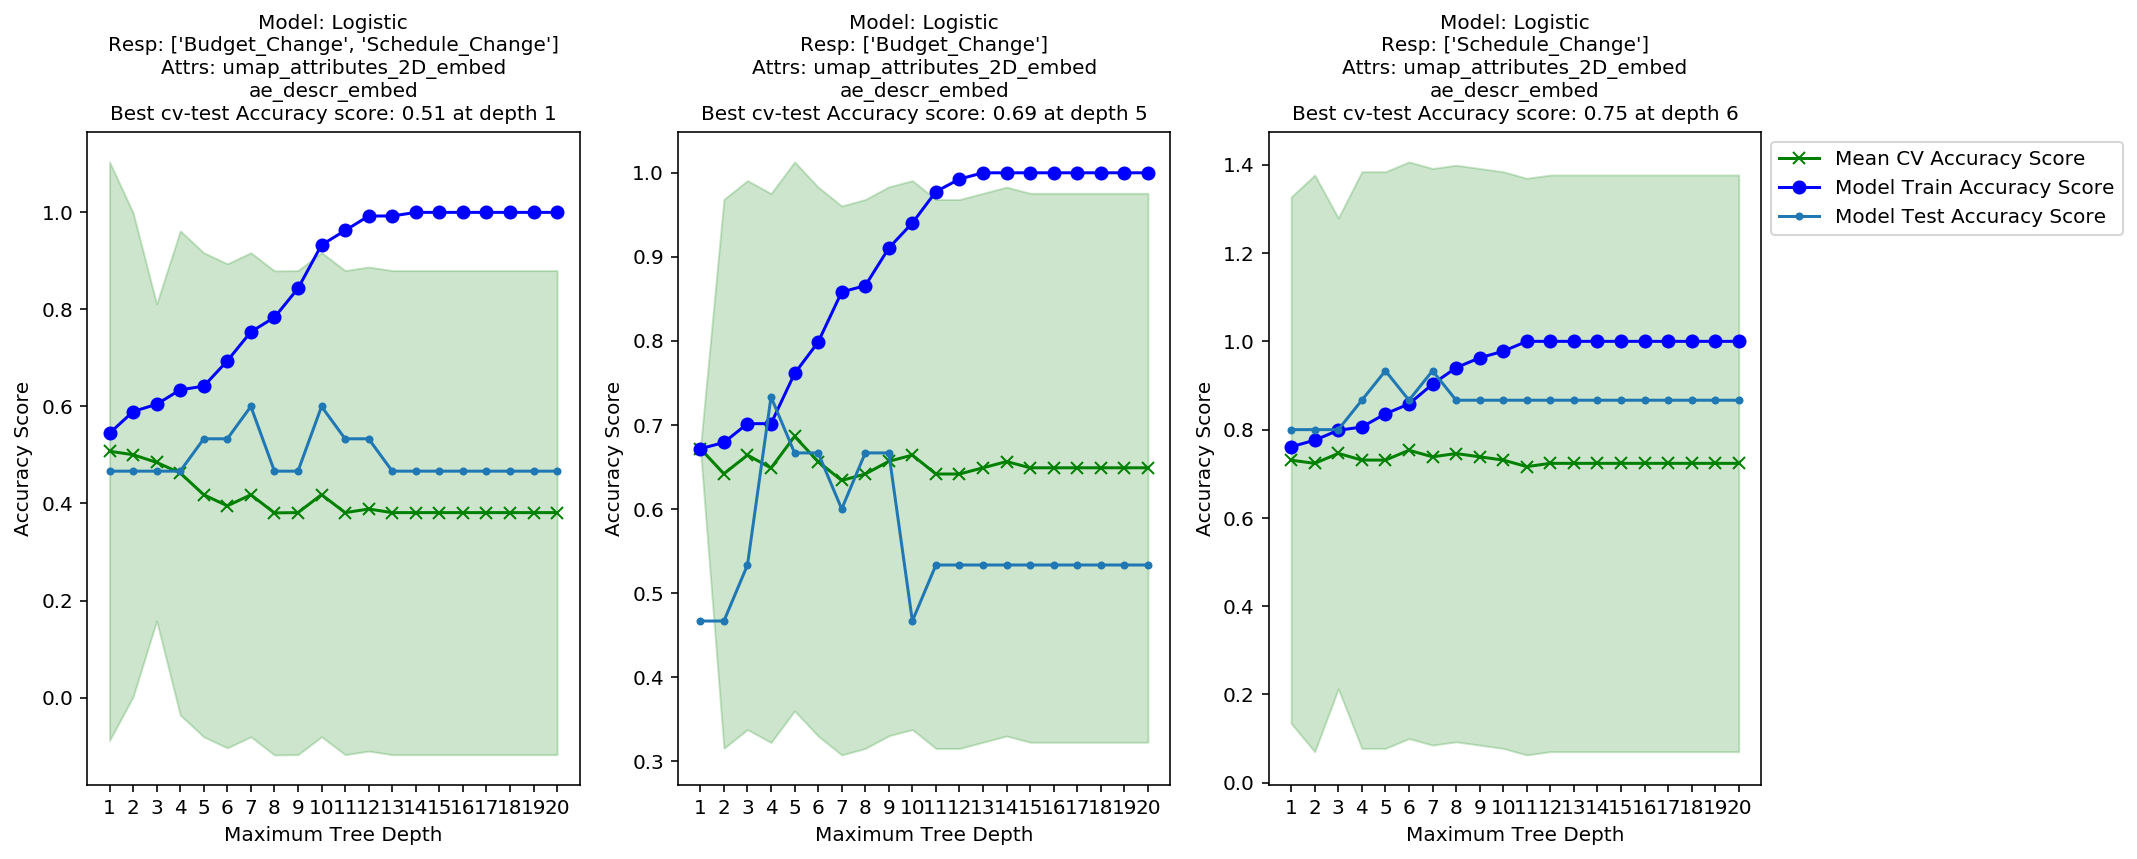

In [353]:
resp = 'Budget_Change'
max_score = results_df[log_results_df[resp]==1].test_score.max()
idx = results_df[(results_df[resp]==1) & (results_df.test_score==max_score)].sort_values(by='best_cv_score').iloc[0].name
print(f"Index Chosen: {idx}")

m_dict = results_df.iloc[idx]
attributes = m_dict.attributes
responses_list = [['Budget_Change','Schedule_Change'], ['Budget_Change'], ['Schedule_Change']]
_, _ = plot_tree(data_train, data_test, attributes=attributes, responses_list=responses_list, logistic=logistic, plot=True)

print(f"Best Test Score of Model Chosen: {round(m_dict.get('test_score'),4)} // Depth: {m_dict.get('best_depth')}")
print(f"Model Attributes: {m_dict.get('attributes')}")
print(f"Model Response: {m_dict.get('responses')}")

tree_dot_data = tree.export_graphviz(m_dict.best_model, feature_names=m_dict.full_attributes)
gr = graphviz.Source(tree_dot_data)
display(gr)

### Although the Best Depths are different, the best model attributes are the same for the best performing 'Schedule Change' and best performing 'Budget_Change' models.  Both perform best when using UMAP to embed the attributes and the Auto-Encoder to encode the project description.

### Conclusion for this model set:

### Best Attribute Combination is 'UMAP Attribute Embedding' + 'Auto-Encoder Description'

## Using Regression Models

In [354]:
# calculate all combinations of modeling options of attribute and responses
results_all = []
model_dicts = []

nondescr_attrbutes = ['Category', 'Budget_Start', 'Duration_Start', 'umap_attributes_2D_embed']
descr_attributes = ['umap_descr_2D_embed', 'ae_descr_embed', 'pca_descr_embed']
logistic = False
print("Using REGRESSION models")
for i in tqdm(range(1, len(nondescr_attrbutes))):
    alist = list(itertools.combinations(nondescr_attrbutes, i))
    for a in tqdm(alist, leave=False):
        a = list(a)
        results, model_dict = plot_tree(data_train, data_test, attributes=a, responses_list=responses_list, logistic=logistic, plot=False)
        results_all += results
        model_dicts.append(model_dict)
        for d_emb in tqdm(descr_attributes, leave=False):
            results, model_dict = plot_tree(data_train, data_test, attributes=a + [d_emb], responses_list=responses_list, logistic=logistic, plot=False)
            results_all += results
            model_dicts.append(model_dict)
    

Using REGRESSION models


In [358]:
results_df = pd.DataFrame(results_all)


In [359]:
results_df.sort_values(by='test_score', ascending=False)


,attributes,full_attributes,responses,Budget_Change,Schedule_Change,Budget_and_Schedule_Change,best_cv_score,best_depth,train_score,test_score,best_model
41,"[Category, Duration_Start]","[Duration_Start, Bridges, Ferries, Industrial_...",[Schedule_Change],0,1,0,0.45,5,0.44,0.45,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
111,"[Budget_Start, Duration_Start, umap_attributes...","[Budget_Start, Duration_Start, umap_attributes...",[Schedule_Change],0,1,0,0.42,9,0.93,0.42,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
103,"[Category, Duration_Start, umap_attributes_2D_...","[Duration_Start, Bridges, Ferries, Industrial_...",[Schedule_Change],0,1,0,0.40,10,0.96,0.40,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
79,"[Duration_Start, umap_attributes_2D_embed, pca...","[Duration_Start, umap_attributes_2D_embed_1, u...",[Schedule_Change],0,1,0,0.35,7,0.86,0.35,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
105,"[Budget_Start, Duration_Start, umap_attributes...","[Budget_Start, Duration_Start, umap_attributes...",[Schedule_Change],0,1,0,0.33,6,0.64,0.33,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
...,...,...,...,...,...,...,...,...,...,...,...
22,"[Duration_Start, pca_descr_embed]","[Duration_Start, pca_descr_embed_1, pca_descr_...",[Budget_Change],1,0,0,-1.29,1,0.05,-1.29,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
40,"[Category, Duration_Start]","[Duration_Start, Bridges, Ferries, Industrial_...",[Budget_Change],1,0,0,-1.29,1,0.05,-1.29,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
42,"[Category, Duration_Start, umap_descr_2D_embed]","[Duration_Start, Bridges, Ferries, Industrial_...",[Budget_Change],1,0,0,-1.29,1,0.05,-1.29,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
44,"[Category, Duration_Start, ae_descr_embed]","[Duration_Start, Bridges, Ferries, Industrial_...",[Budget_Change],1,0,0,-1.29,1,0.05,-1.29,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."


### Review Best Performing Model with 'Schedule Change' Response


Index Chosen: 41
Best Test Score of Model Chosen: 0.4453 // Depth: 5
Model Attributes: ['Category', 'Duration_Start']
Model Response: ['Schedule_Change']


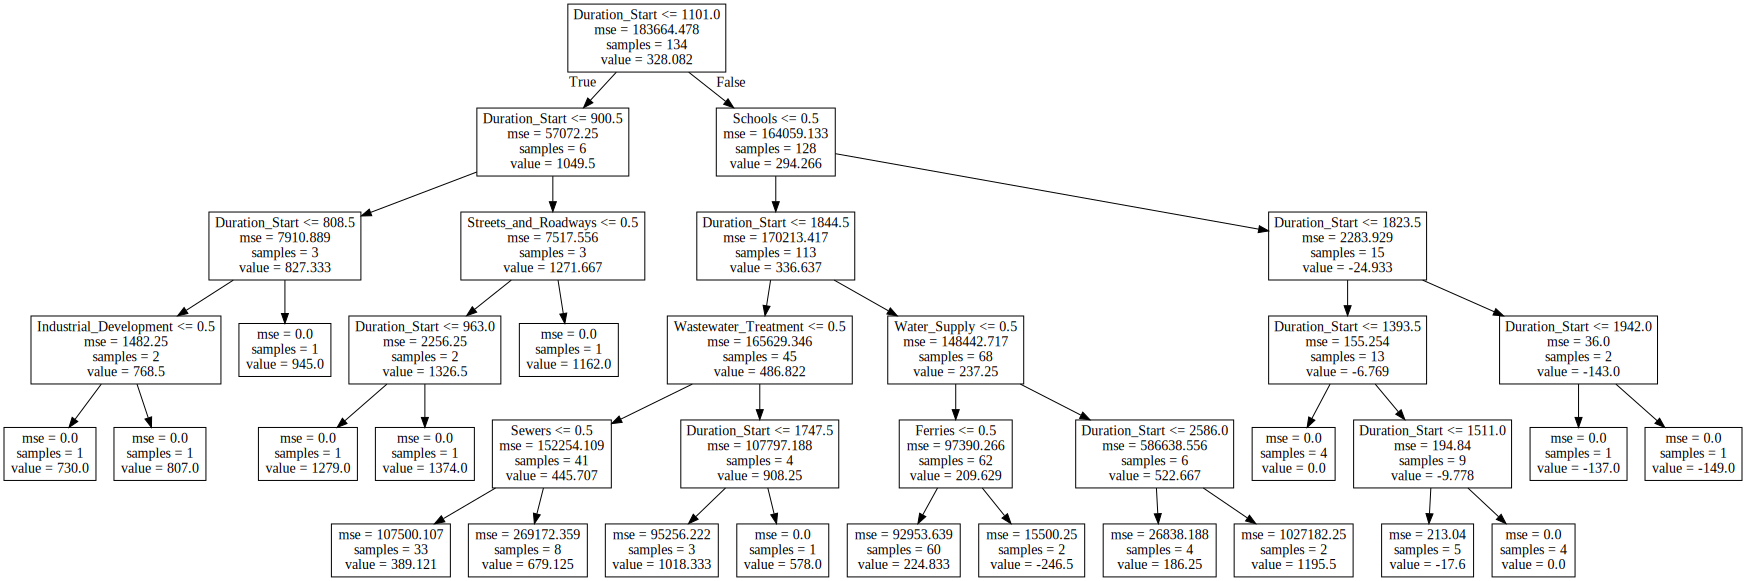


MODEL SUMMARY:
Regression Tree. Depth: 5


The fitted model object(s):

	DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=109, splitter='best')

	DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=109, splitter='best')


This model resulted in the following R-squared scores:

	Budget_Change

		Training	0.9300
		Test		-24.7471

	Schedule_Change

		

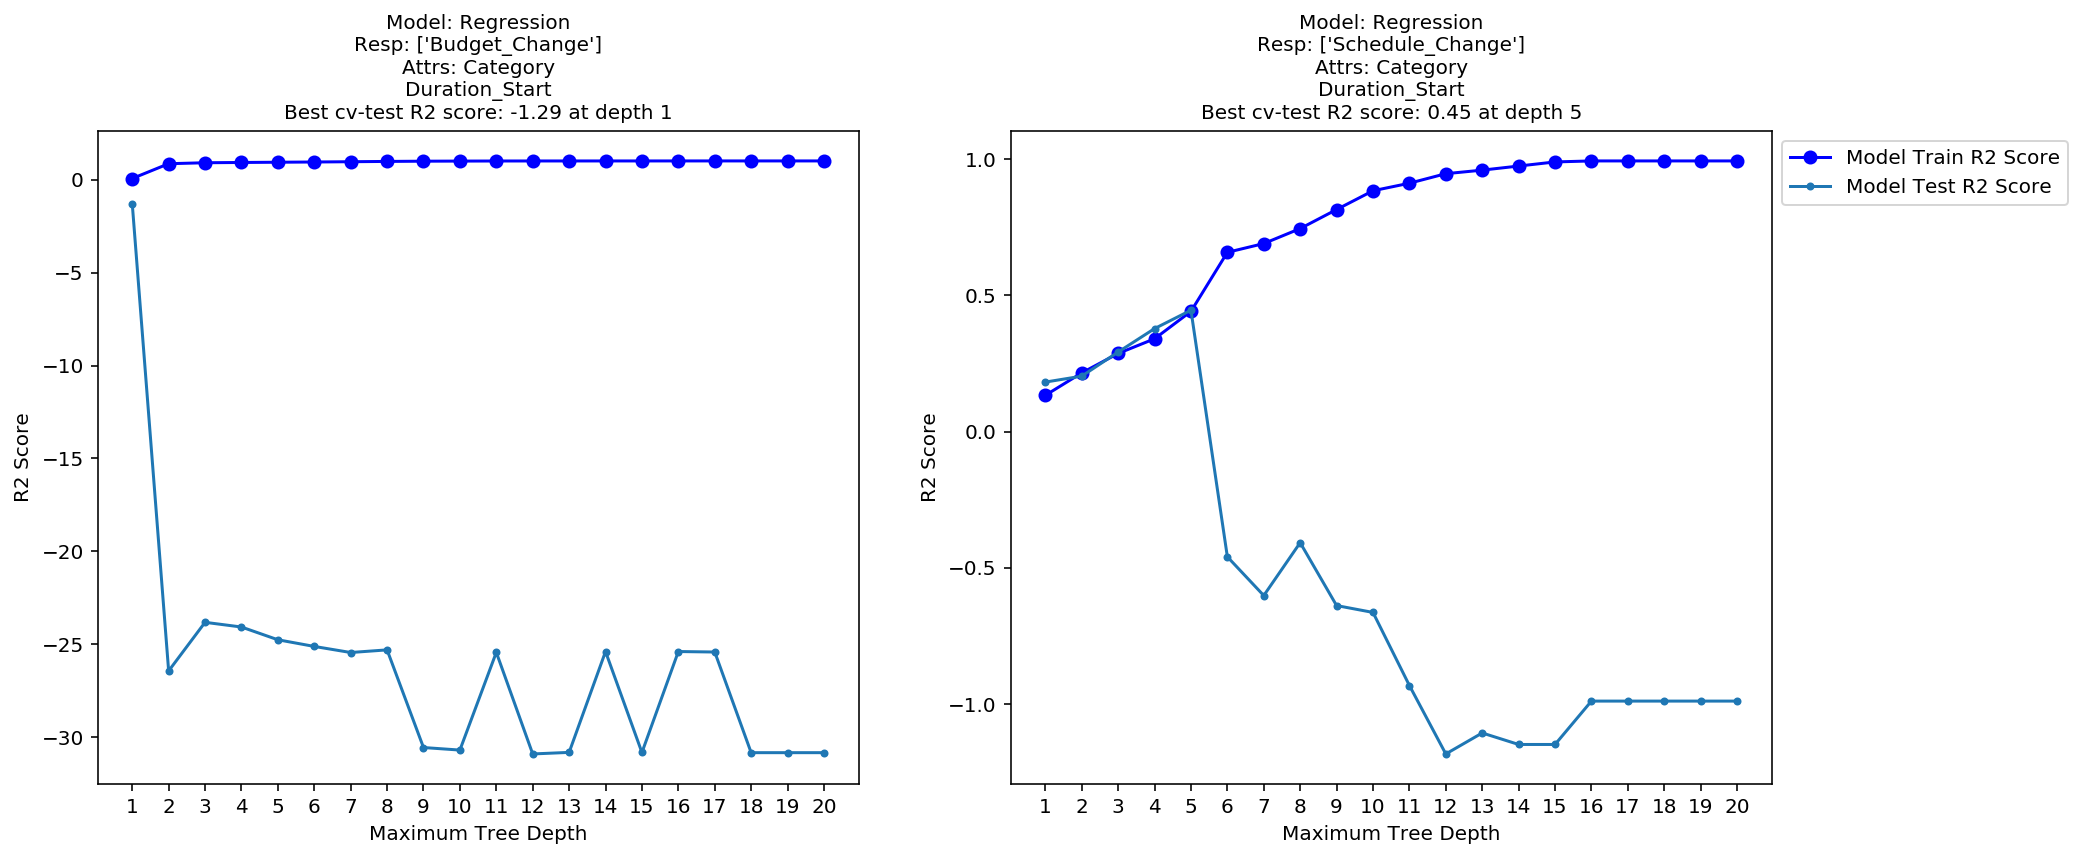

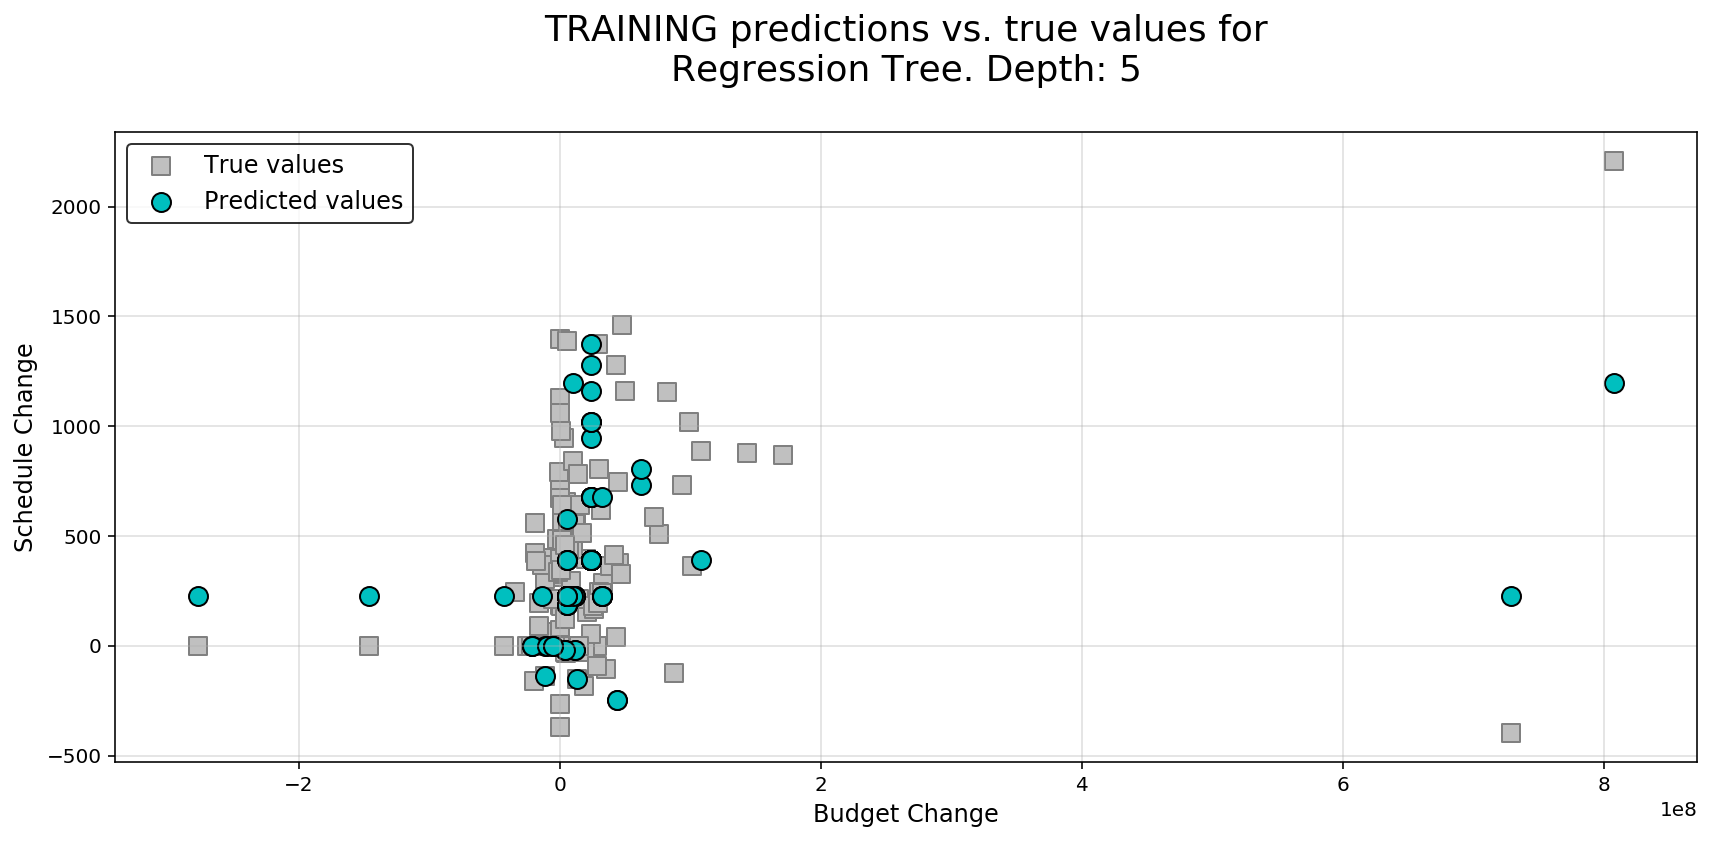

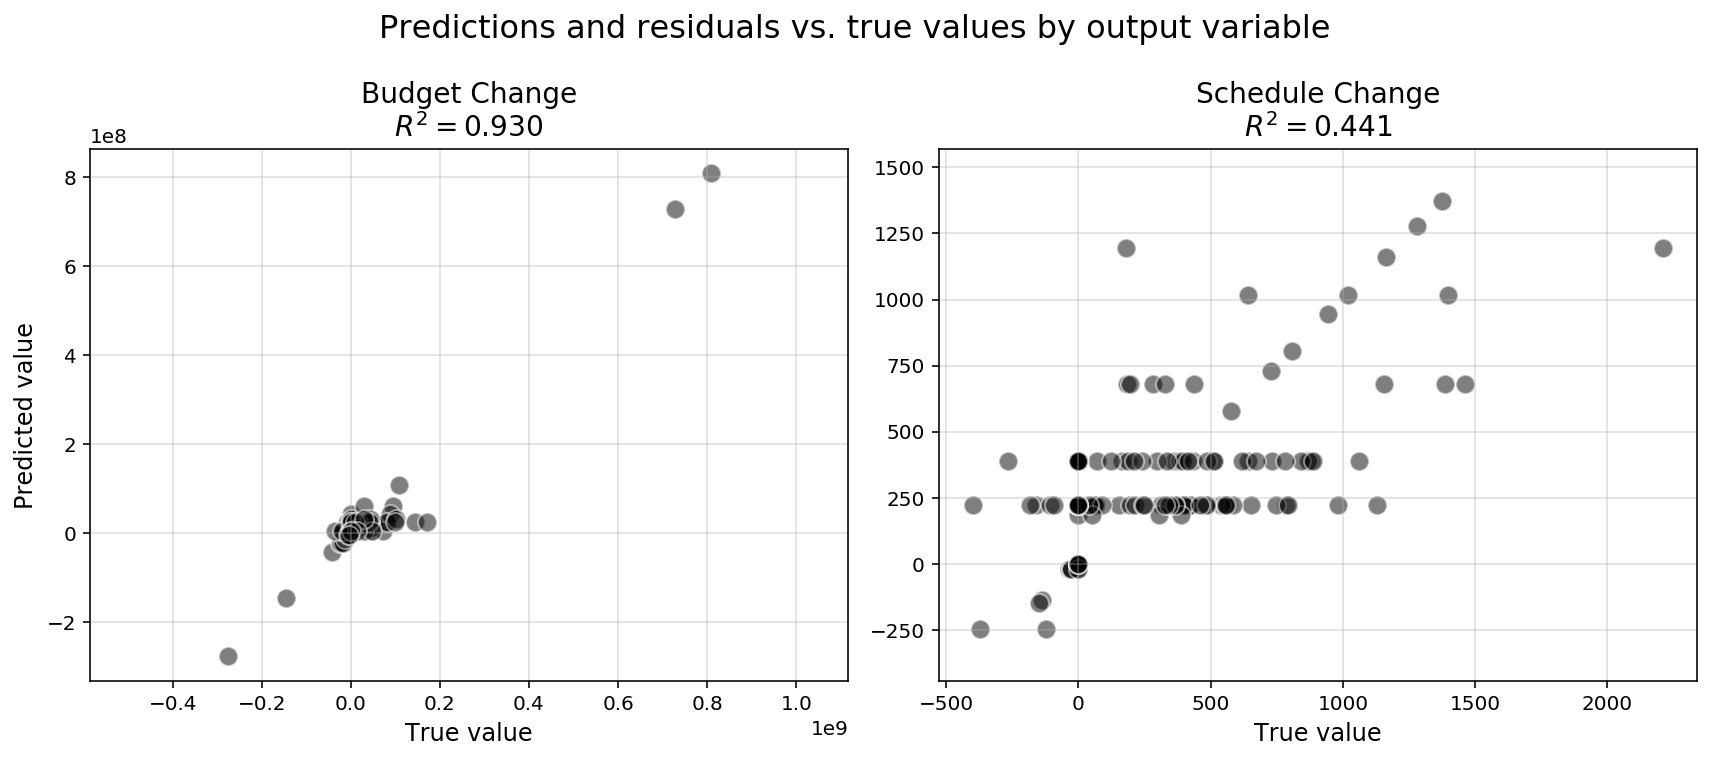

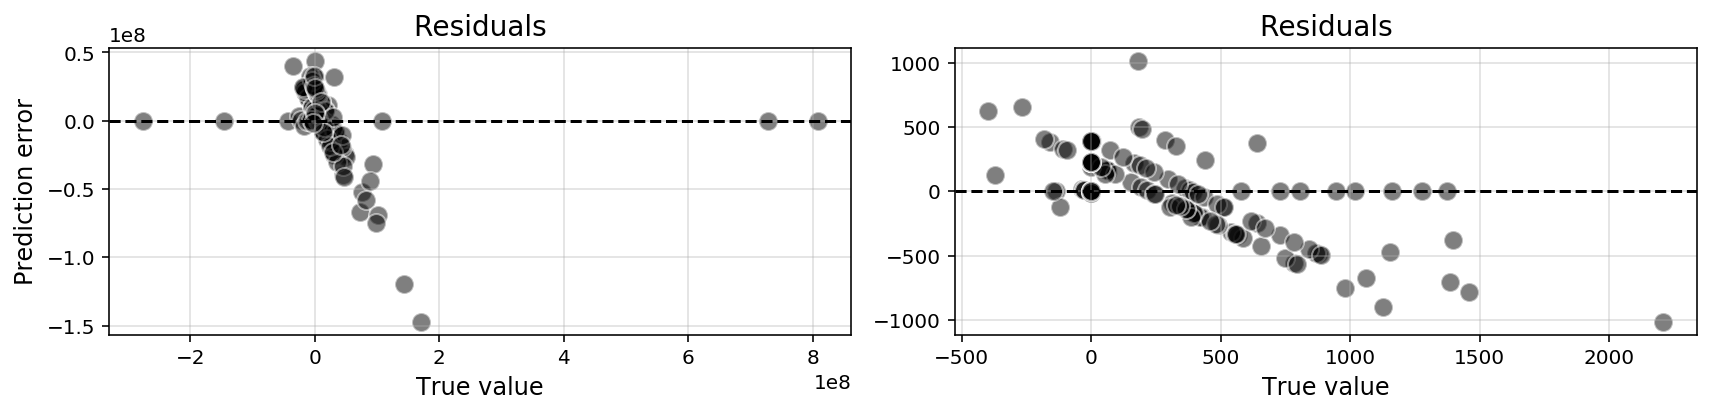

In [383]:
resp = 'Schedule_Change'
max_score = results_df[results_df[resp]==1].test_score.max()
idx = results_df[(results_df[resp]==1) & (results_df.test_score==max_score)].sort_values(by='best_cv_score').iloc[0].name
print(f"Index Chosen: {idx}")

m_dict = results_df.iloc[idx]
attributes = m_dict.attributes
responses_list = [['Budget_Change','Schedule_Change'], ['Budget_Change'], ['Schedule_Change']]
_, _ = plot_tree(data_train, data_test, attributes=attributes, responses_list=responses_list, logistic=logistic, plot=True)

print(f"Best Test Score of Model Chosen: {round(m_dict.get('test_score'),4)} // Depth: {m_dict.get('best_depth')}")
print(f"Model Attributes: {m_dict.get('attributes')}")
print(f"Model Response: {m_dict.get('responses')}")

tree_dot_data = tree.export_graphviz(m_dict.best_model, feature_names=m_dict.full_attributes)
gr = graphviz.Source(tree_dot_data)
display(gr)


# Plot Scoring
m_dict = reg_results_df.iloc[idx]
best_depth = m_dict.best_depth
attrs = m_dict.full_attributes

desc = f"{'Logistic' if logistic else 'Regression'} Tree. Depth: {best_depth}"
X_tr, X_te, y_tr, y_te = define_train_and_test(data_train, data_test, attrs, ['Budget_Change', 'Schedule_Change'], logistic=logistic)

model_dict = generate_model_dict(model=DecisionTreeClassifier if logistic else DecisionTreeRegressor, 
                                         model_descr=desc, 
                                         X_train=X_tr, 
                                         X_test=X_te, 
                                         y_train=y_tr, 
                                         y_test=y_te, 
                                         multioutput=logistic,
                                         verbose=False,
                                         predictions=True,
                                         scores=True,
                                         model_api='sklearn',
                                         sm_formulas=None,
                                         y_stored=True,
                                         max_depth=best_depth, 
                                         random_state=109)

print_model_results(model_dict)
plot_true_pred(model_dict)

Index Chosen: 74
Best Test Score of Model Chosen: 0.2491 // Depth: 20
Model Attributes: ['Duration_Start', 'umap_attributes_2D_embed', 'umap_descr_2D_embed']
Model Response: ['Budget_Change']


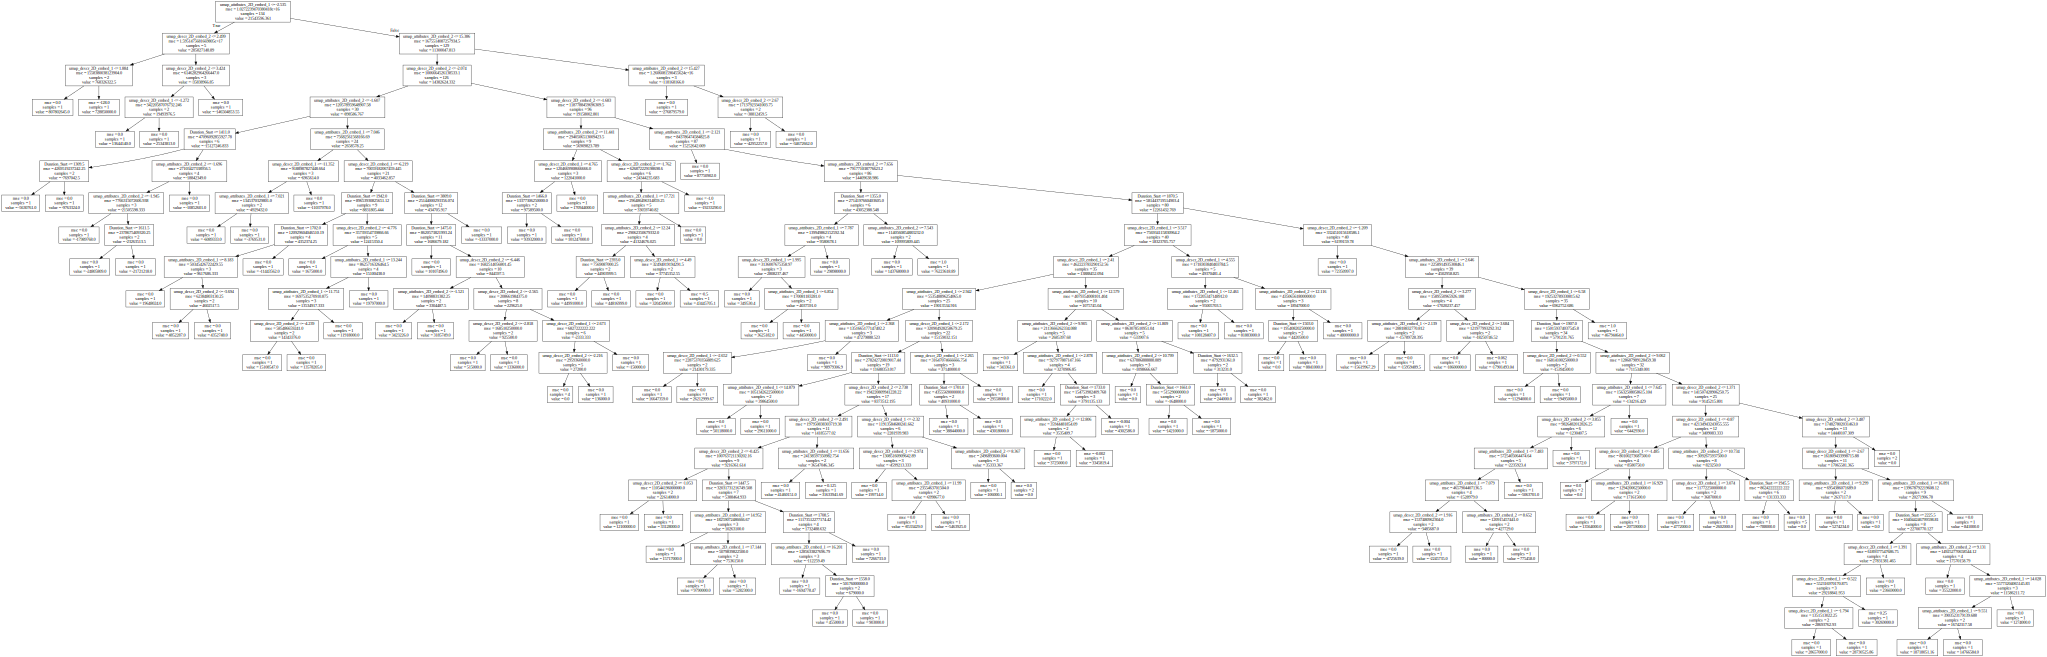

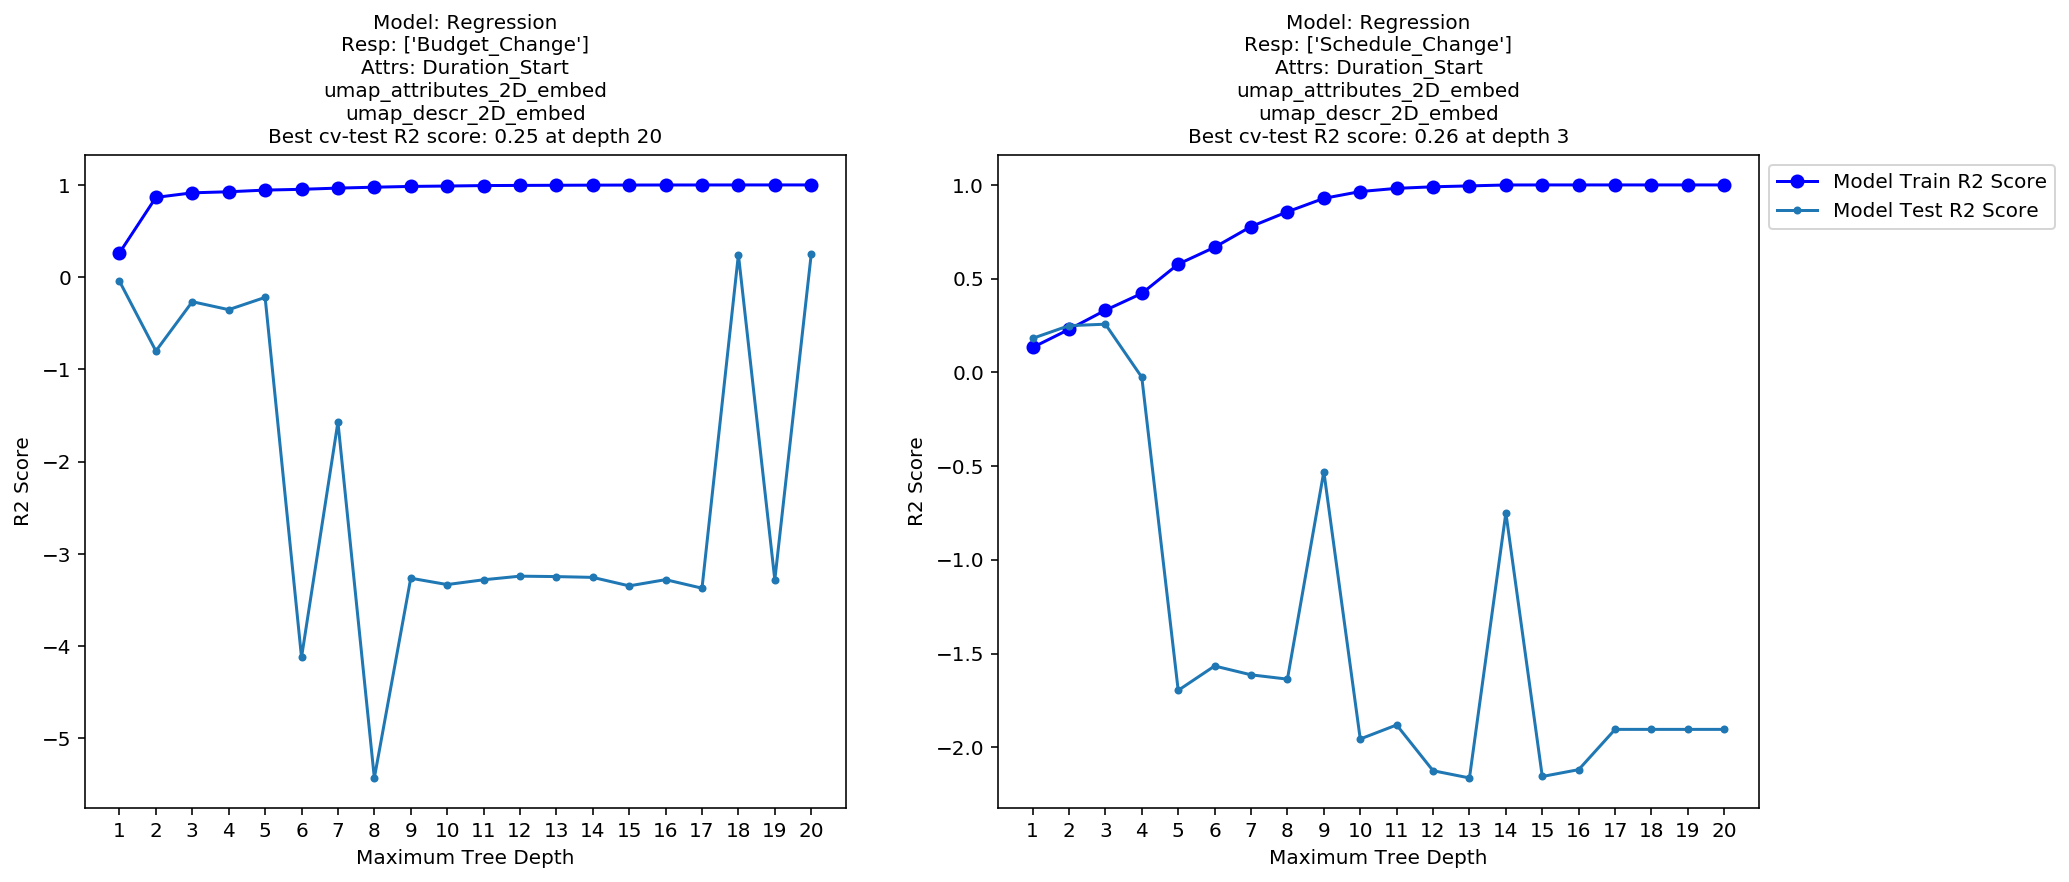

In [388]:
resp = 'Budget_Change'
max_score = results_df[results_df[resp]==1].test_score.max()
idx = results_df[(results_df[resp]==1) & (results_df.test_score==max_score)].sort_values(by='best_cv_score').iloc[0].name
print(f"Index Chosen: {idx}")

m_dict = results_df.iloc[idx]
attributes = m_dict.attributes
responses_list = [['Budget_Change','Schedule_Change'], ['Budget_Change'], ['Schedule_Change']]
_, _ = plot_tree(data_train, data_test, attributes=attributes, responses_list=responses_list, logistic=logistic, plot=True)

print(f"Best Test Score of Model Chosen: {round(m_dict.get('test_score'),4)} // Depth: {m_dict.get('best_depth')}")
print(f"Model Attributes: {m_dict.get('attributes')}")
print(f"Model Response: {m_dict.get('responses')}")

tree_dot_data = tree.export_graphviz(m_dict.best_model, feature_names=m_dict.full_attributes)
gr = graphviz.Source(tree_dot_data)
display(gr)

# # Plot Scoring
# m_dict = reg_results_df.iloc[idx]
# best_depth = m_dict.best_depth
# attrs = m_dict.full_attributes

# desc = f"{'Logistic' if logistic else 'Regression'} Tree. Depth: {best_depth}"
# X_tr, X_te, y_tr, y_te = define_train_and_test(data_train, data_test, attrs, ['Budget_Change', 'Schedule_Change'], logistic=logistic)

# model_dict = generate_model_dict(model=DecisionTreeClassifier if logistic else DecisionTreeRegressor, 
#                                          model_descr=desc, 
#                                          X_train=X_tr, 
#                                          X_test=X_te, 
#                                          y_train=y_tr, 
#                                          y_test=y_te, 
#                                          multioutput=logistic,
#                                          verbose=False,
#                                          predictions=True,
#                                          scores=True,
#                                          model_api='sklearn',
#                                          sm_formulas=None,
#                                          y_stored=True,
#                                          max_depth=best_depth, 
#                                          random_state=109)

# print_model_results(model_dict)
# plot_true_pred(model_dict)

### As before, the best models are different for predicting 'Schedule_Change' and 'Budget_Change.

### The best 'Schedule_Change' prediction model uses 'Category' and  'Duration_Start' and doesn't used any embeddings at all.

### The best 'Budget_Change' prediction model uses 'UMAP_Attribites' and 'UMPA_Description' embiddings to determine the best result.

## Random Forest
Extend the Decision Tree concept by creating a forest of trees where each tree in the forest is a decision tree model with a random starting point.  Using a random forest may uncover some hidden relationships that the decision tree may not find.

In [39]:
n_trees = 150
tree_depth = 6
rf = RandomForestClassifier(   n_estimators=n_trees, 
                               max_depth=tree_depth, 
                               bootstrap=True,
                               oob_score=True,
                               n_jobs=-1, 
                               random_state=0)

In [40]:
# for the forest, we will use all attributes and responses.  Non-essential variables will be 'weeded out' by the forest model.
attributes = [  'Category',
                'Borough',
                'Managing_Agency',
                'Client_Agency',
                'Budget_Start',
                'Duration_Start' ]

dummy_columns = ['Category', 'Borough', 'Managing_Agency', 'Client_Agency']

responses_list = [['Budget_Change','Schedule_Change'], ['Budget_Change'], ['Schedule_Change']]

X_tr, X_te, y_tr, y_te, dummies_dict = define_train_and_test(data, dummy_columns, attributes, responses_list[0], logistic==True) 


In [41]:
rf.fit(X_tr, y_tr)
random_forest_train_score = rf.score(X_tr, y_tr)
random_forest_test_score = rf.score(X_te, y_te)
print("Random Forest performance with {} baggings and tree depth of {}:".format(n_trees, tree_depth))
print("\tRandom Forest Train Score: {}%".format(round(random_forest_train_score*100,2)))
print("\tRandom Forest Test Score: {}%".format(round(random_forest_test_score*100,2)))

Random Forest performance with 150 baggings and tree depth of 6:
	Random Forest Train Score: 73.88%
	Random Forest Test Score: 26.67%


In [42]:
pd.DataFrame({'features':X_tr.columns, 'importance':rf.feature_importances_}).sort_values(by='importance', ascending=False).head()


,features,importance
1,Duration_Start,0.19
0,Budget_Start,0.14
11,Schools,0.08
36,DOE,0.07
28,SCA,0.07
